# ModTox: Predict toxicology towards CYP2C9 

1) Cluster a 250 nanoseconds molecular dynamics to extract 10 conformations of the receptor.

2) Dock a set of active/inactive compounds


3) Fit and predict a stack of 5 ML models to the resultant docking features.


4) Predict over the test set


5) Postprocess the result to retrieve the uncertanty of the predictions and the ROC, PR, and confusion matrix

In [81]:
import os
import numpy as np
import modtox.ML.preprocess as Pre
import modtox.ML.postprocess as Post
import modtox.ML.model2 as model
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

## Cluster a Molecular dynamics simulation into 10 clusters

## Dock a dataset of active/inactive compounds

## Load active, inactives and docking data

Provide a sdf of active, a sdf with decoys and a csv with any external feature you want.
In this case, the external features will be the docking terms of glide docking over 10 different receptors

In [2]:
folder = "tests_2/data/"
sdf_active = os.path.join(folder, "actives.sdf")
sdf_inactive = os.path.join(folder, "inactives.sdf")
csv = os.path.join(folder, "glide_features.csv")

## Generate features, dropnans and filter unwanted columns

1) Generate features such as:

- MACCS fingerprints
- Daylight fingerprints
- Topological descriptors
- External csv with features

2) Sanitize: Drop all Nan samples (non docked)

3) Filter: Remove unwanted columns

In [3]:
pre = Pre.ProcessorSDF(csv=csv, fp=False, descriptors=False, MACCS=True, columns=None)
print("Fit and tranform for preprocessor..")
X, y = pre.fit_transform(sdf_active=sdf_active, sdf_inactive=sdf_inactive)
print("Sanitazing...")
pre.sanitize(X, y)
print("Filtering features...")
pre.filter_features(X)

Fit and tranform for preprocessor..
tests_2/data/actives.sdf tests_2/data/inactives.sdf
Active, Inactive
114 114
Read Active, Read Inactive
114 114
Non Repited Active, Non Repited Inactive
114 114
Shape Dataset
228
	Building MACS Fingerprints
	Incorporating external data


/Users/nostrum/repos/modtox/modtox/ML/external_descriptors.py:46: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df = pd.concat([df.ix[:i-1], null_line, df.ix[i:]]).reset_index(drop=True)


Sanitazing...
Filtering features...


(array([[  0. ,   0. ,   0. , ..., -67. , -40.5,   9.8],
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
        [  0. ,   0. ,   0. , ..., -59.6, -41.4,   8.4],
        ...,
        [  0. ,   0. ,   0. , ...,   nan,   nan,   nan],
        [  0. ,   0. ,   0. , ..., -28.2, -30.5,  19.5],
        [  0. ,   0. ,   0. , ..., -13.7,  -9.6,   9.9]]),
 ['rdkit_fingerprintMACS_0',
  'rdkit_fingerprintMACS_1',
  'rdkit_fingerprintMACS_10',
  'rdkit_fingerprintMACS_100',
  'rdkit_fingerprintMACS_101',
  'rdkit_fingerprintMACS_102',
  'rdkit_fingerprintMACS_103',
  'rdkit_fingerprintMACS_104',
  'rdkit_fingerprintMACS_105',
  'rdkit_fingerprintMACS_106',
  'rdkit_fingerprintMACS_107',
  'rdkit_fingerprintMACS_108',
  'rdkit_fingerprintMACS_109',
  'rdkit_fingerprintMACS_11',
  'rdkit_fingerprintMACS_110',
  'rdkit_fingerprintMACS_111',
  'rdkit_fingerprintMACS_112',
  'rdkit_fingerprintMACS_113',
  'rdkit_fingerprintMACS_114',
  'rdkit_fingerprintMACS_115',
  'rdkit_fingerprintMACS_116'

## Fit  model

Choose between:

- A stack of 5 models (clf='stack')
- A single model optimized with tpot (clf='single')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
#fit model
Model = model.GenericModel(clf='stack', tpot=True)
print("Fitting model...")
Model.fit(X_train,y_train)

Fitting model...


Generation 1 - Current best internal CV score: 0.8938905180840665

Best pipeline: LogisticRegression(GaussianNB(input_matrix), C=25.0, dual=True, penalty=l2)


Generation 1 - Current best internal CV score: 0.9687377810361681

Best pipeline: LogisticRegression(SelectFwe(input_matrix, alpha=0.046), C=25.0, dual=False, penalty=l2)


Generation 1 - Current best internal CV score: 0.9304313294232649

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=11)


Generation 1 - Current best internal CV score: 0.9308345552297166

Best pipeline: BernoulliNB(SelectPercentile(input_matrix, percentile=4), alpha=1.0, fit_prior=True)


Generation 1 - Current best internal CV score: 0.9306329423264907

Best pipeline: DecisionTreeClassifier(KNeighborsClassifier(input_matrix, n_neighbors=31, p=1, weights=uniform), criterion=gini, max_depth=6, min_samples_leaf=9, min_samples_split=19)


/Users/nostrum/.local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))
/Users/nostrum/.local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


Generation 1 - Current best internal CV score: 1.0

Best pipeline: LogisticRegression(input_matrix, C=15.0, dual=False, penalty=l1)


In [6]:
#fit model
Model = model.GenericModel(clf='single', tpot=True)
print("Fitting model...")
Model.fit(X_train,y_train)

Fitting model...


Generation 1 - Current best internal CV score: 0.8938905180840665

Best pipeline: LogisticRegression(GaussianNB(input_matrix), C=25.0, dual=True, penalty=l2)


## Predict on test

In [7]:
#predict model
print("Predicting...")
y_pred = Model.predict(X_test, y_test) 

Predicting...
Loading models


## Analyse results

Analyse results by checking:

1) Metrics

- ROC curve
- PR curve
- Confusion matrix

2) Feature Importance

- Shap Values (Permutation importance)
- XGboost (Gain relevance)

3) Uncertanties

- Distribution of train&test descriptors
- Applicability domain
- Majority voting

4) Dimensionality reduction

- UMAP
- TSNE
- PCA

In [14]:
pp = Post.PostProcessor('stack', x_test=Model.X_test_trans, y_true_test=Model.Y_test,
                        y_pred_test=Model.prediction_test, y_proba_test=Model.predictions_proba_test,
                        x_train=Model.X_trans, y_true_train=Model.Y)

### Metrics

In [15]:
ROC = pp.ROC()

In [16]:
PR = pp.PR()

    P   N
P  27   4
N   6  32


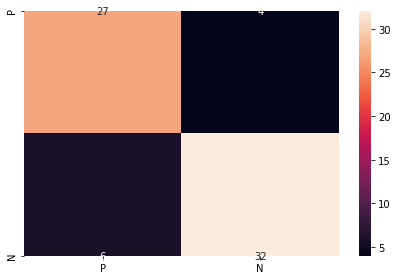

In [17]:
DA = pp.conf_matrix()

### Feature importance

/Users/nostrum/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


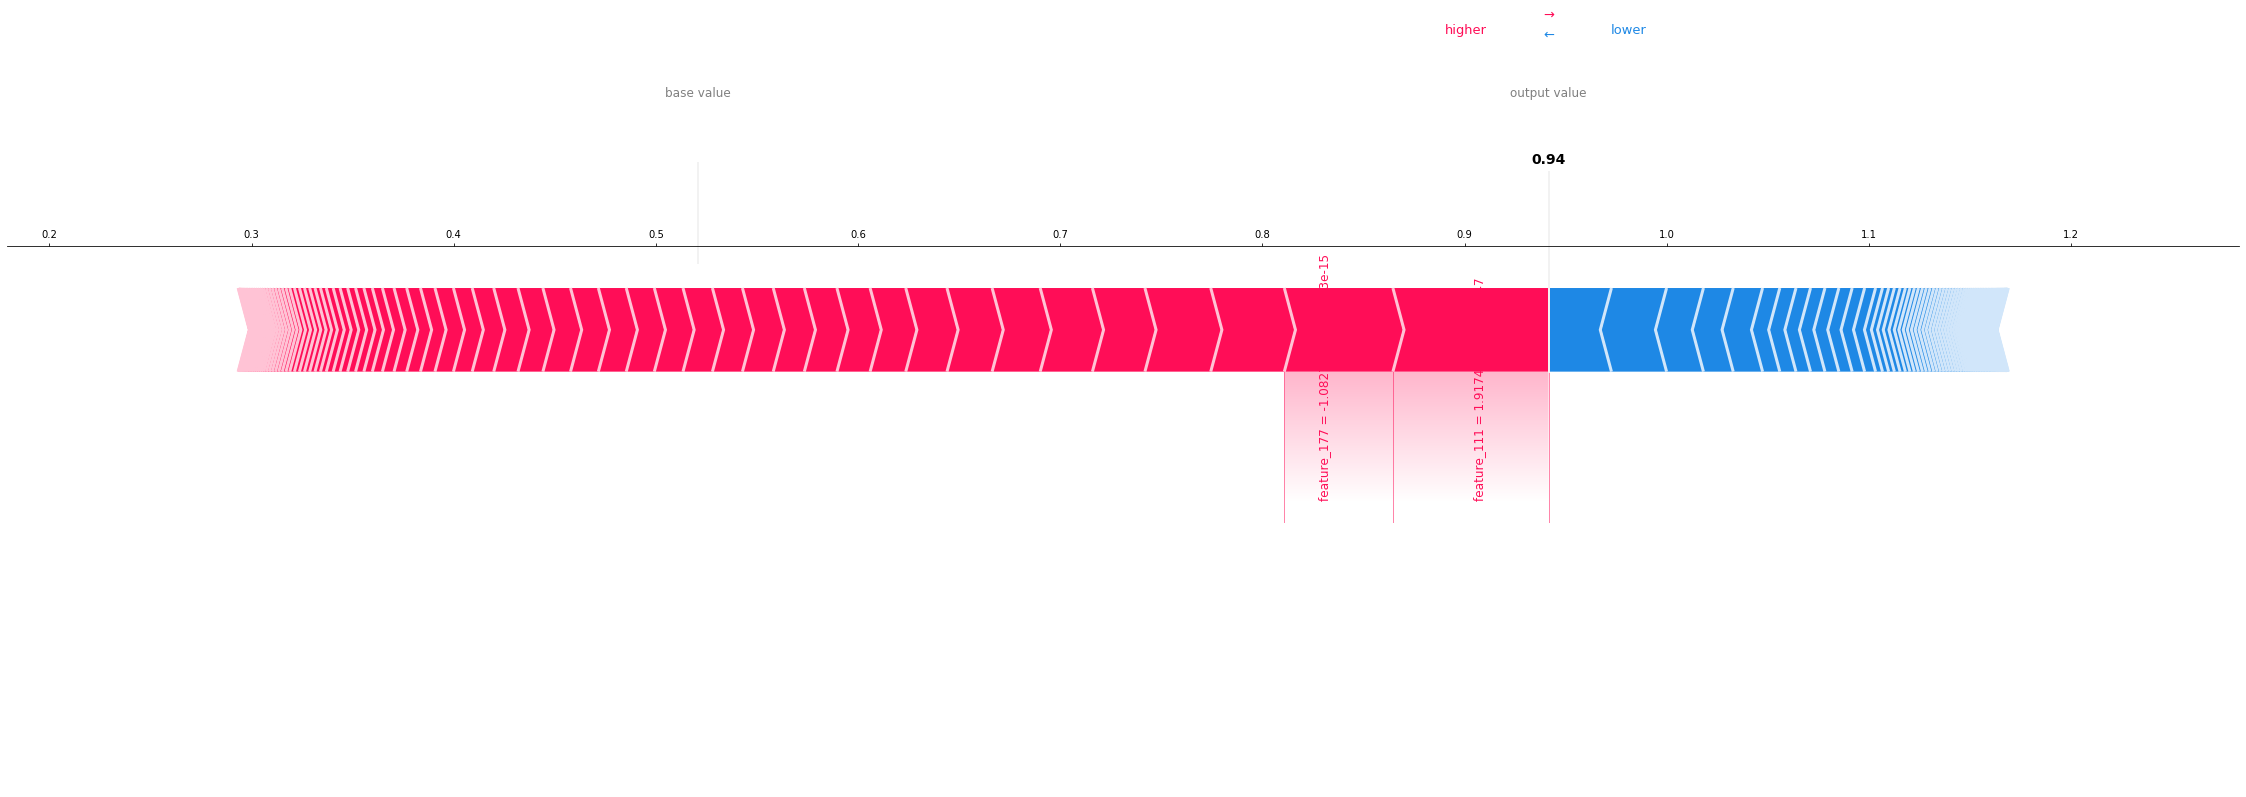

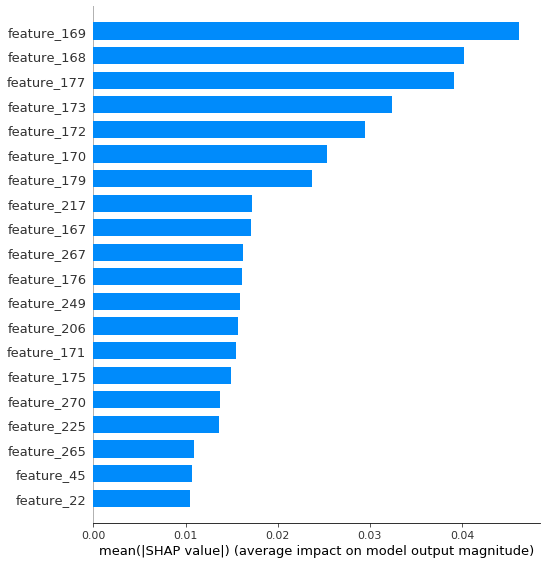

In [18]:
SH = pp.shap_values(debug=True)

In [19]:
FI = pp.feature_importance()

Extracting most importance features


### Uncertanties on predict

#### Descriptor distributions between test and train features.

In [20]:
DD = pp.distributions(debug=True)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/nostrum/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/nostrum/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


#### Applicability domain of test samples

In [21]:
DA = pp.domain_analysis()

  0%|          | 0/69 [00:00<?, ?it/s]

Computing applicability domains
Plotting


100%|██████████| 69/69 [00:18<00:00,  3.76it/s]


#### Uncertanty based on the results of the predictions of all classifiers

In [22]:
UN = pp.calculate_uncertanties()

TypeError: 'NoneType' object is not subscriptable

#### Dimensionanlity reduction

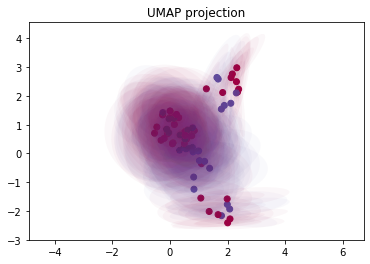

In [23]:
pp.UMAP_plot()

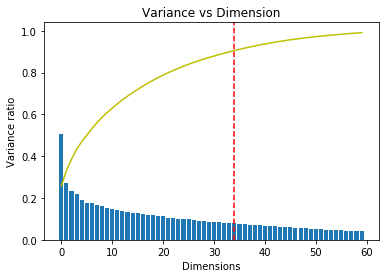

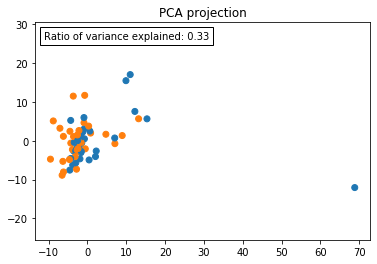

In [24]:
pp.PCA_plot()

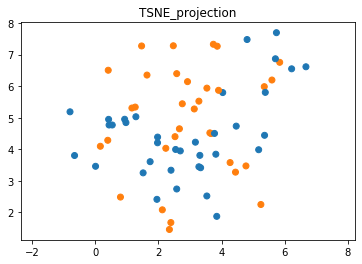

In [25]:
pp.tsne_plot()

# Use ModTox as API for your ML

In [68]:
 X, y = make_blobs(n_samples=100, centers=2, n_features=2,
                 random_state=0)

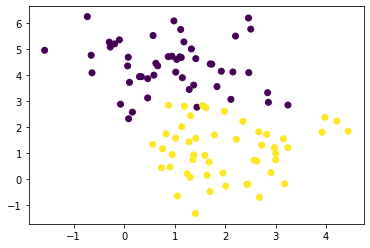

In [79]:
plt.scatter(X[:,0], X[:,1], c=y)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
#fit model
Model = model.GenericModel(clf='single', tpot=True)
print("Fitting model...")
Model.fit(X_train,y_train)

Fitting model...


Generation 1 - Current best internal CV score: 0.9447619047619048

Best pipeline: GaussianNB(input_matrix)


In [51]:
y_pred = Model.predict(X_test, y_test) 

Loading models


In [52]:
y_pred

[True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [53]:
pp = Post.PostProcessor('single', x_test=Model.X_test_trans, y_true_test=Model.Y_test,
                        y_pred_test=Model.prediction_test, y_proba_test=Model.predictions_proba_test,
                        x_train=Model.X_trans, y_true_train=Model.Y)

In [54]:
ROC = pp.ROC()

In [55]:
PR = pp.PR()

    P   N
P  17   0
N   2  11


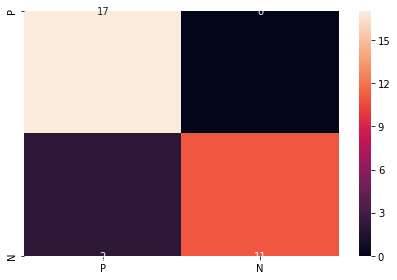

In [56]:
DA = pp.conf_matrix()

/Users/nostrum/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
  0%|          | 0/1 [00:00<?, ?it/s]/Users/nostrum/anaconda3/lib/python3.7/site-packages/shap/plots/force_matplotlib.py:106: RuntimeWarning: divide by zero encountered in double_scalars
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)
100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


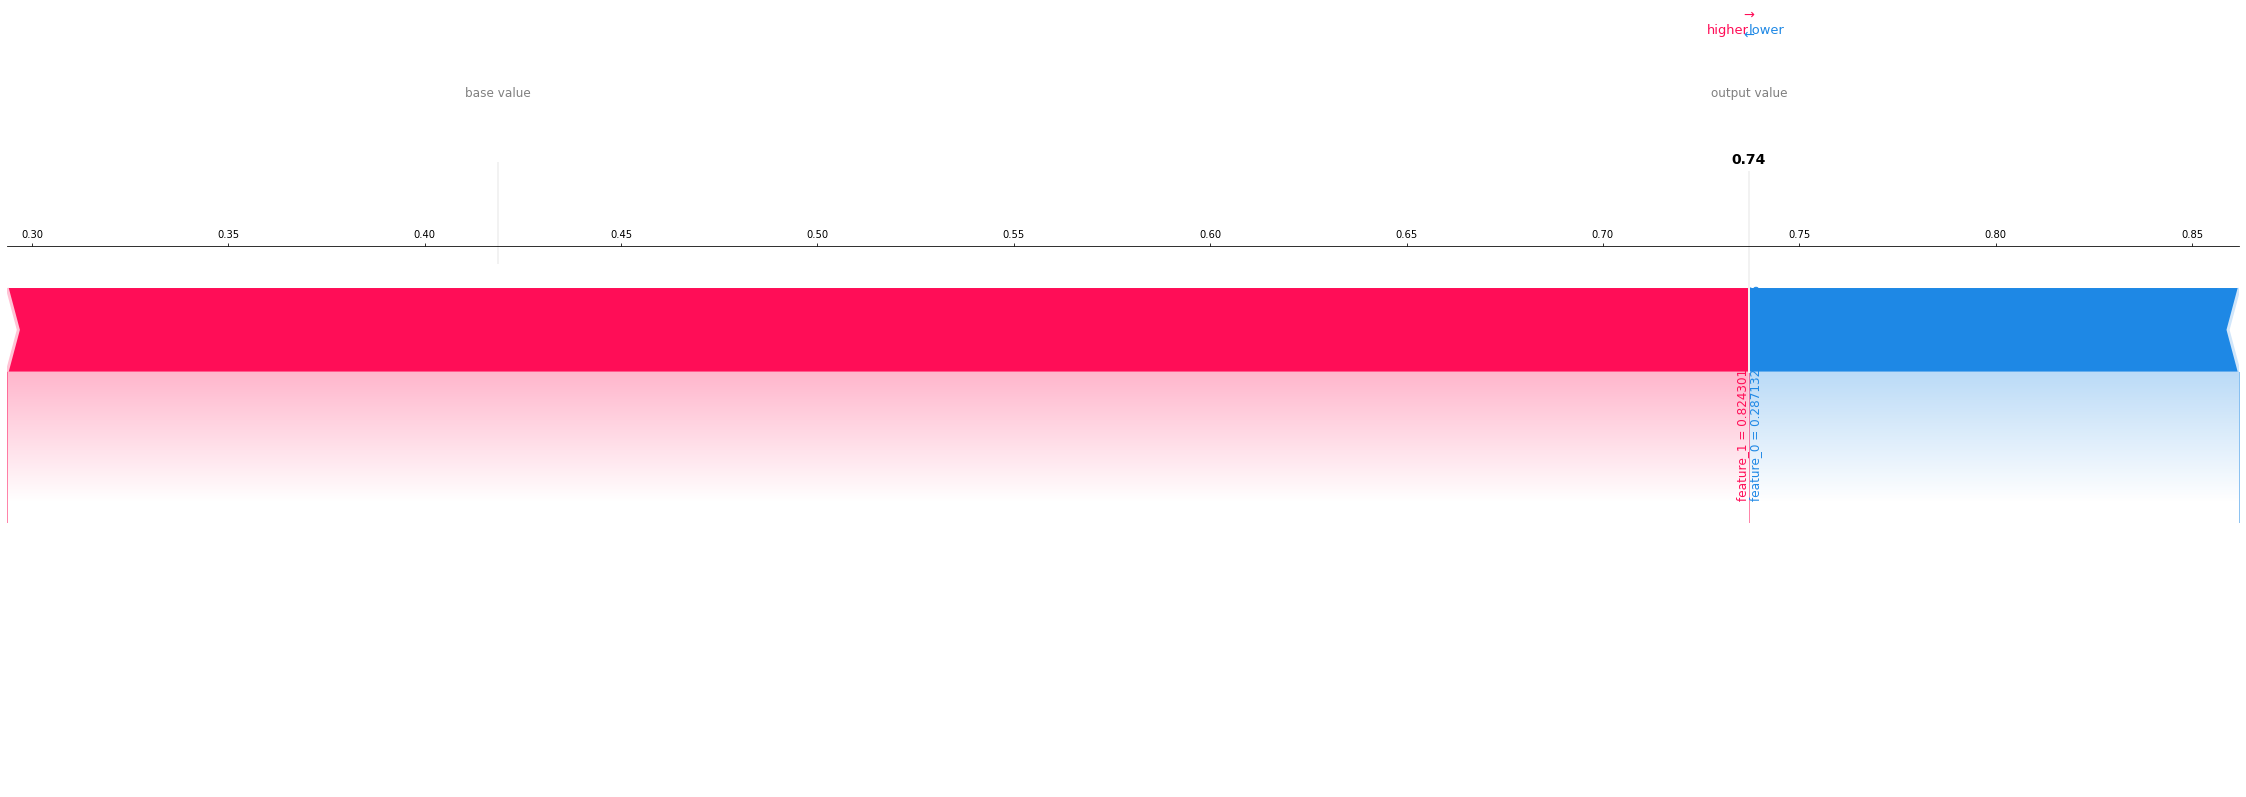

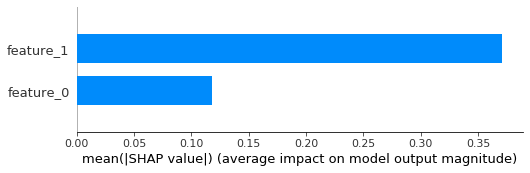

In [57]:
SH = pp.shap_values(debug=True)

In [58]:
FI = pp.feature_importance()

Extracting most importance features


In [59]:
DA = pp.domain_analysis()

  0%|          | 0/30 [00:00<?, ?it/s]

Computing applicability domains
Plotting


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


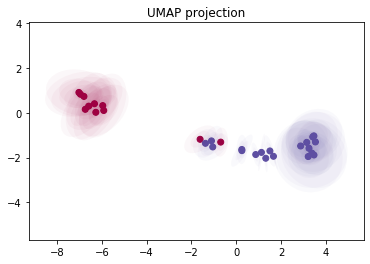

In [60]:
pp.UMAP_plot()

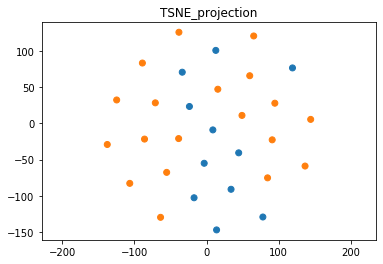

In [61]:
pp.tsne_plot()

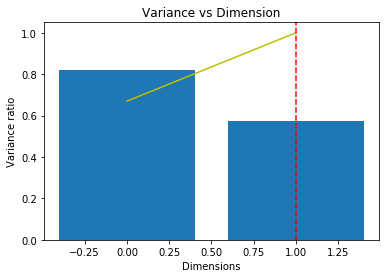

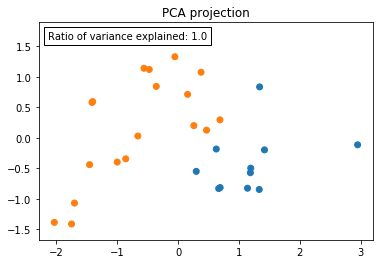

In [62]:
pp.PCA_plot()